In [9]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import gen_data
import qp_solver
import util
import parametric_si

import networkx as nx

In [10]:
def compute_c_d(X, a, b, p, lamda):
    dim_beta = p
    dim_z = p - 1
    no_vars = p + 2 * dim_z

    e_1 = lamda * np.hstack((np.zeros(dim_beta), np.ones(2 * dim_z)))
    e_2 = np.hstack((np.dot(X.T, a).flatten(), np.zeros(2 * dim_z)))

    c = e_1 - e_2
    d = np.hstack((-np.dot(X.T, b).flatten(), np.zeros(2 * dim_z)))

    c = c.reshape((no_vars, 1))
    d = d.reshape((no_vars, 1))

    return c, d


def construct_P_q_G_h_A_b(X, y, D, n, p, lamda):
    dim_beta = p
    dim_z = p - 1
    no_vars = p + 2 * dim_z

    # construct P
    e_1 = np.hstack((X, np.zeros((n, 2 * dim_z))))
    P = np.dot(e_1.T, e_1)

    # construct q
    e_1 = lamda * np.hstack((np.zeros(dim_beta), np.ones(2 * dim_z)))
    e_2 = np.hstack((np.dot(X.T, y).flatten(), np.zeros(2 * dim_z)))
    q = e_1 - e_2
    q = q.reshape((no_vars, 1))

    # construct G
    G = np.zeros((no_vars, no_vars))
    G[dim_beta:, dim_beta:] = np.zeros((2 * dim_z, 2 * dim_z)) - np.identity(2 * dim_z)

    # construct h
    h = np.zeros((no_vars, 1))

    # construct A
    e_1 = np.hstack((np.identity(dim_z), np.zeros((dim_z, dim_z)) - np.identity(dim_z)))
    A = np.hstack((-D, e_1))

    # construct b
    b = np.zeros((D.shape[0], 1))

    return P, q, G, h, A, b


In [11]:
m_1 = 8
m_2 = 8

nodes = range(1,m_1*m_2+1)
edges = []
for i in nodes:
    if(i%m_1!=0):
        edges.append([i,i+1])
    if((i+m_1)<(m_1*m_2+1)):
        edges.append([i,i+m_2])
        
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

incidence_matrix = -nx.incidence_matrix(G, oriented=True) 


In [20]:
n = m_1*m_2
p = n
X = np.identity(n)
D = np.transpose(incidence_matrix.toarray())

# There are three piecewise constant regions
true_y_2d = np.zeros((m_1,m_2))
true_y_2d[5:8,5:8] = 3
true_y_2d[0:3,0:3] = -3

np.random.seed(1234)
true_y = true_y_2d.flatten() #np.zeros(n)
y = true_y + np.random.normal(0, 1, n)
lamda = 4

y = y.reshape((n, 1))
true_y = true_y.reshape((n, 1))

Text(0.5, 1.0, 'True mean')

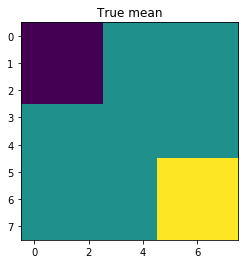

In [21]:
plt.imshow(true_y_2d)
plt.title("True mean")

Text(0.5, 1.0, 'Noisy observation')

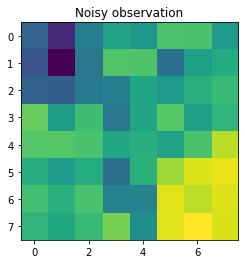

In [22]:
plt.imshow(y.reshape((8,8)))
plt.title("Noisy observation")

In [23]:
P, q, G, h, A, b = construct_P_q_G_h_A_b(X, y, D, n, p, lamda)

dim_x = p + 2 * (p - 1)
x, prob = qp_solver.run(P, q, G, h, A, b, dim_x)

x = x.value

beta = x[0:p]
list_cp = util.find_list_cp(beta, p)

if len(list_cp) == 2:
    return None

cp_selected_idx = np.random.randint(1, len(list_cp) - 1)
cp_selected = list_cp[cp_selected_idx]

pre_cp = list_cp[cp_selected_idx - 1]
next_cp = list_cp[cp_selected_idx + 1]
n_s_1 = cp_selected - pre_cp
n_s_2 = next_cp - cp_selected

etaj = np.zeros(n)
etaj[pre_cp + 1 : cp_selected + 1] = np.ones(n_s_1) / n_s_1
etaj[cp_selected + 1 : next_cp + 1] = - np.ones(n_s_2) / n_s_2
etaj = etaj.reshape((n, 1))

etajTy = np.dot(etaj.T, y)[0][0]

a_line, b_line = util.compute_a_b(y, etaj, n)

c, d = compute_c_d(X, a_line, b_line, p, lamda)

path_zk, path_list_cp = parametric_si.run_parametric_si(P, c, d, G, h, A, b, p, dim_x, z_threshold)

tn_mu = np.dot(etaj.T, true_y)[0][0]
cov = np.identity(n)
pivot = util.pivot(list_cp, path_zk, path_list_cp, etaj, etajTy, cov, tn_mu)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 112 and the array at index 1 has size 63